# **Dzongkha Sign Language Detection**

Bhutan set up the program for the deaf in a hearing school in Thimphu (capital of Bhutan) ca. 2000, and the first dedicated school, in Paro (place in Bhutan), was approved in 2013. Deaf education includes developing BSL, Bhutanese Sign Language as the language of instruction. 

Deep Learning plays important role to classify BSL to communicate with disable people in Bhutan, deaf. Convolutional Neural Network, CNN is the most prominent algorithm to detect and recognize the sign language (computer vision application).


Connect with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras

In [ ]:
import zipfile

# Unzip the dataset
local_zip = '/content/drive/MyDrive/dzo.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

In [ ]:
train_dir = '/content/dataset/dzo/train'
validation_dir = '/content/dataset/dzo/val'
test_dir = '/content/dataset/dzo/test' 

Unzips the dataset file named "dzo.zip" from the Google drive and saves it in the "dataset" folder

**Preprocessing - Image Data Generator**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#generating batches of tensor image data
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=15,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 10500 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.
Found 1500 images belonging to 30 classes.


Generates batches of tensor image data by applying various image augmentation techniques such as rotation, shearing, zooming, horizontal flipping, and fill mode. It also rescales the pixel values of images to the range of 0-1. These batches are then passed on to the training, validation, and test generators respectively. The flow_from_directory function loads images from the directory specified and assigns labels based on the subdirectories' names.

Check the length of the train generator, validation generator and test generator

In [ ]:
len(train_generator), len(validation_generator), len(test_generator)

(329, 94, 47)

In [ ]:
print(train_generator.class_indices)

{'ahh': 0, 'ba': 1, 'cha': 2, 'chaa': 3, 'dha': 4, 'dza': 5, 'ga': 6, 'ha': 7, 'ja': 8, 'ka': 9, 'kha': 10, 'la': 11, 'ma': 12, 'na': 13, 'nga': 14, 'nya': 15, 'pa': 16, 'pha': 17, 'ra': 18, 'sa': 19, 'sha': 20, 'ta': 21, 'tha': 22, 'tsa': 23, 'tsaaa': 24, 'uaa': 25, 'wa': 26, 'ya': 27, 'za': 28, 'zha': 29}


**Class Weights Calculation**

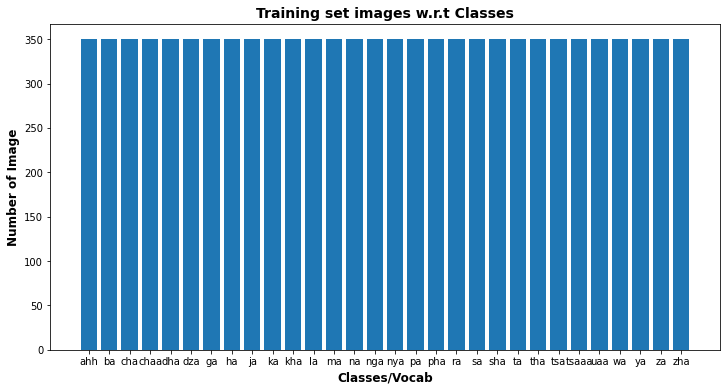

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from collections import OrderedDict

cls_train = train_generator.classes
classes = list(train_generator.class_indices.keys())

num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))

for i in range(30):
    num_values.append(valdict[i])
plt.figure(figsize=(12, 6))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)

plt.xlabel('Classes/Vocab', weight='bold').set_fontsize('12')
plt.ylabel('Number of Image', weight='bold').set_fontsize('12')
plt.title('Training set images w.r.t Classes', weight='bold').set_fontsize('14')
plt.savefig("train", facecolor='w', bbox_inches="tight", pad_inches=0.1)
plt.show() 

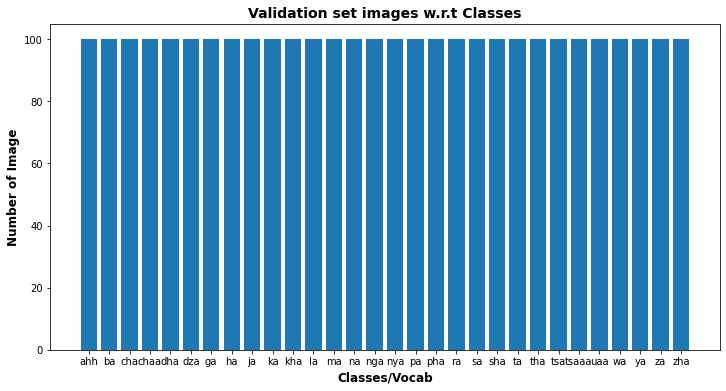

In [ ]:
cls_test = validation_generator.classes
classes = list(validation_generator.class_indices.keys())

num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))

for i in range(30):
    num_values.append(valdict[i])
plt.figure(figsize=(12,6))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)

plt.xlabel('Classes/Vocab', weight='bold').set_fontsize('12')
plt.ylabel('Number of Image', weight='bold').set_fontsize('12')
plt.title('Validation set images w.r.t Classes', weight='bold').set_fontsize('14')
plt.savefig("validation", facecolor='w', bbox_inches="tight", pad_inches=0.1)
plt.show() 

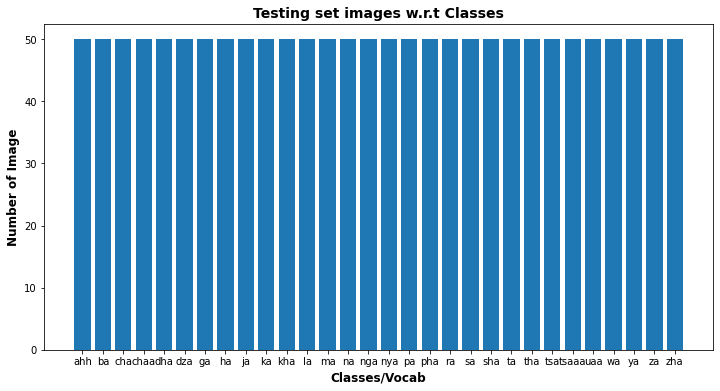

In [ ]:
cls_test = test_generator.classes
classes = list(test_generator.class_indices.keys())

num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))

for i in range(30):
    num_values.append(valdict[i])
plt.figure(figsize=(12, 6))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)

plt.xlabel('Classes/Vocab', weight='bold').set_fontsize('12')
plt.ylabel('Number of Image', weight='bold').set_fontsize('12')
plt.title('Testing set images w.r.t Classes', weight='bold').set_fontsize('14')
plt.savefig("test", facecolor='w', bbox_inches="tight", pad_inches=0.1)
plt.show() 

It calculates the class weights to deal with the class imbalance problem in the dataset. It first extracts the class labels from the training and validation generators, then calculates the number of images in each class and plots them using the Matplotlib library. This helps us visualize the class imbalance problem and decide the class weights accordingly.

# **2. Model Architecture - CNN Model**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(30, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

Compile the model

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

In [ ]:
#Early stopping to avoid overfitting of model
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

Fit the CNN model using model.fit()

In [ ]:
history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=30,
      steps_per_epoch=len(train_generator), # total images = batch_size * steps
      validation_steps=len(validation_generator), # total images = batch_size * steps
      callbacks = [early_stop],
      verbose=1)

Epoch 1/30
329/329 [==============================] - 135s 381ms/step - loss: 2.9577 - accuracy: 0.1330 - val_loss: 2.3841 - val_accuracy: 0.2580
Epoch 2/30
329/329 [==============================] - 125s 381ms/step - loss: 2.2179 - accuracy: 0.3041 - val_loss: 1.9001 - val_accuracy: 0.3780
Epoch 3/30
329/329 [==============================] - 124s 377ms/step - loss: 1.6948 - accuracy: 0.4620 - val_loss: 1.2990 - val_accuracy: 0.5917
Epoch 4/30
329/329 [==============================] - 124s 377ms/step - loss: 1.3187 - accuracy: 0.5734 - val_loss: 1.1248 - val_accuracy: 0.6520
Epoch 5/30
329/329 [==============================] - 124s 378ms/step - loss: 1.0677 - accuracy: 0.6546 - val_loss: 0.8200 - val_accuracy: 0.7370
Epoch 6/30
329/329 [==============================] - 124s 377ms/step - loss: 0.8414 - accuracy: 0.7259 - val_loss: 0.6918 - val_accuracy: 0.7903
Epoch 7/30
329/329 [==============================] - 125s 380ms/step - loss: 0.6997 - accuracy: 0.7736 - val_loss: 0.6447 -

Check the accuracy and loss of CNN model

In [ ]:
loss, accuracy = model.evaluate(train_generator, verbose=1)

329/329 [==============================] - 118s 358ms/step - loss: 0.1113 - accuracy: 0.9652


In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)

94/94 [==============================] - 6s 63ms/step - loss: 0.2347 - accuracy: 0.9403


In [ ]:
test_score = model.evaluate(test_generator, verbose=1)

print("Accuracy: {:.2f} %".format(test_score[1]*100)) 
print("Loss: ", test_score[0])

47/47 [==============================] - 3s 73ms/step - loss: 0.3335 - accuracy: 0.9173
Accuracy: 91.73 %
Loss:  0.33348700404167175


Plot the accuracy and loss of CNN model

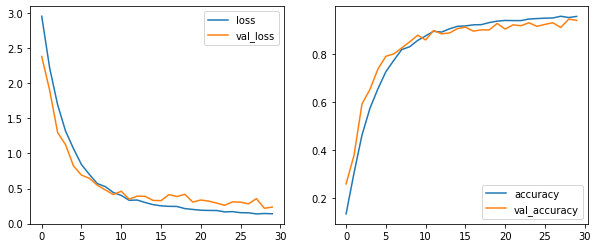

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])
plt.savefig("cnn_performance", facecolor='w', bbox_inches="tight", pad_inches=0.1)
plt.show()

Save the CNN model in .h5 for future use

In [ ]:
model.save('cnn.h5')

In [ ]:
classes_name = test_generator.class_indices
print('Dictionary : ', classes_name)
classes_name = list(classes_name.keys())
print('List of class name : ', classes_name)

Dictionary :  {'ahh': 0, 'ba': 1, 'cha': 2, 'chaa': 3, 'dha': 4, 'dza': 5, 'ga': 6, 'ha': 7, 'ja': 8, 'ka': 9, 'kha': 10, 'la': 11, 'ma': 12, 'na': 13, 'nga': 14, 'nya': 15, 'pa': 16, 'pha': 17, 'ra': 18, 'sa': 19, 'sha': 20, 'ta': 21, 'tha': 22, 'tsa': 23, 'tsaaa': 24, 'uaa': 25, 'wa': 26, 'ya': 27, 'za': 28, 'zha': 29}
List of class name :  ['ahh', 'ba', 'cha', 'chaa', 'dha', 'dza', 'ga', 'ha', 'ja', 'ka', 'kha', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'pha', 'ra', 'sa', 'sha', 'ta', 'tha', 'tsa', 'tsaaa', 'uaa', 'wa', 'ya', 'za', 'zha']


Build the Confusion matrix of the CCN model

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(12,12))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', weight='bold').set_fontsize('12')
  plt.xlabel('Predicted label', weight='bold').set_fontsize('12')

In [ ]:
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

print(target_names)

['ahh', 'ba', 'cha', 'chaa', 'dha', 'dza', 'ga', 'ha', 'ja', 'ka', 'kha', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'pha', 'ra', 'sa', 'sha', 'ta', 'tha', 'tsa', 'tsaaa', 'uaa', 'wa', 'ya', 'za', 'zha']


The performance (precision, recall, and F1 score) of the CNN model

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('\n****************** Performance of Model **************\n')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

47/47 [==============================] - 3s 62ms/step

****************** Performance of Model **************

              precision    recall  f1-score   support

         ahh       0.93      0.84      0.88        50
          ba       0.98      0.84      0.90        50
         cha       0.74      0.86      0.80        50
        chaa       0.67      0.84      0.74        50
         dha       0.98      0.90      0.94        50
         dza       0.94      0.94      0.94        50
          ga       0.96      0.92      0.94        50
          ha       0.94      0.92      0.93        50
          ja       0.96      1.00      0.98        50
          ka       0.98      1.00      0.99        50
         kha       0.94      0.88      0.91        50
          la       0.96      0.96      0.96        50
          ma       1.00      0.94      0.97        50
          na       0.90      0.92      0.91        50
         nga       1.00      0.92      0.96        50
         nya       0.96 

Confusion matrix

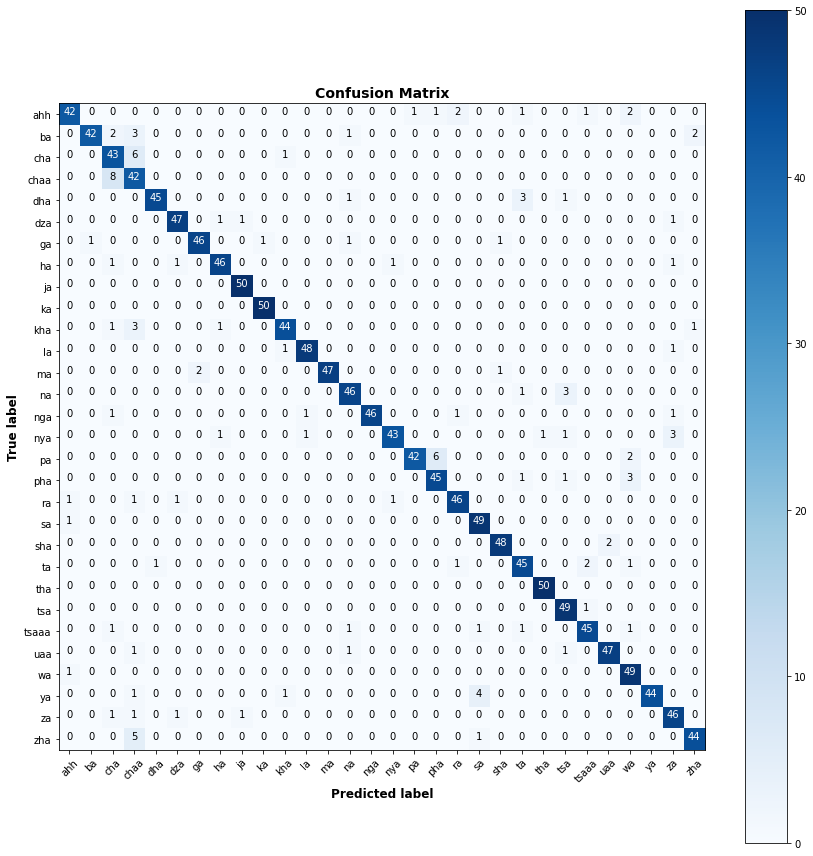

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names)
plt.title('Confusion Matrix', weight='bold').set_fontsize('14')
plt.savefig("cm", facecolor='w', bbox_inches="tight", pad_inches=0.1)
plt.show()

Check the how far the model classify the image correctly

In [ ]:
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  prediction = model.predict(images, batch_size=1)
  print('\n')
  print(prediction[0])

Saving 19.jpg to 19.jpg
1/1 [==============================] - 0s 220ms/step


[8.0600665e-05 2.9978028e-05 5.2338783e-03 1.0195761e-03 2.1294115e-06
 4.5986958e-03 1.7150958e-05 2.2717325e-01 3.8270766e-05 4.3913987e-02
 4.9337864e-02 6.3802415e-01 1.2771971e-09 1.0746310e-04 4.5788128e-04
 1.0473847e-02 2.1957706e-04 1.3125786e-07 4.3246420e-03 1.0740987e-02
 4.1796891e-05 4.2345820e-04 9.2656919e-05 3.8053858e-07 3.7694592e-06
 1.6014848e-03 3.3567668e-04 2.7575479e-06 4.8246526e-04 1.2214581e-03]


In [ ]:
classes = np.argmax(prediction, axis = 1)
classes_list = classes_name[np.argmax(prediction)]
print('The predicted class is {} i.e {}'.format(classes, classes_list))

The predicted class is [11] i.e la


# **2. Model Architecture - VGG16**

Import libraries in VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, MaxPool2D, Activation, Dense, Dropout
from keras.optimizers import Adam
from keras.models import Model

Load pretrained model, VGG16

In [ ]:
conv_base = tf.keras.applications.VGG16(include_top=False,
                                        weights='imagenet', 
                                        input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**i. Without Fine-Tuning**

In [ ]:
# freezing all layers of the base model
for layer in conv_base.layers:
  layer.trainable = False   # conv_base.trainable = False (same function)

Functional API

In [ ]:
# add new layers in existence pretrained model
vgg = Flatten()(conv_base.output)
vgg = Dense(512, activation='relu')(vgg)
vgg = Dense(256, activation='relu')(vgg)
vgg = Dense(128, activation='relu')(vgg)
vgg = Dense(64, activation='relu')(vgg)

output_layer = Dense(30, activation='softmax')(vgg)
    
vgg = Model(inputs=conv_base.input, outputs=output_layer)

vgg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
vgg.compile(
  optimizer = Adam(learning_rate=0.001),
  loss = 'categorical_crossentropy',
  metrics = ['accuracy']
)

In [ ]:
history = vgg.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=30,
      steps_per_epoch=len(train_generator), 
      validation_steps=len(validation_generator), 
      callbacks = [early_stop],
      verbose=1)

Epoch 1/30
329/329 [==============================] - 142s 429ms/step - loss: 1.9776 - accuracy: 0.3906 - val_loss: 0.8428 - val_accuracy: 0.7113
Epoch 2/30
329/329 [==============================] - 142s 430ms/step - loss: 0.7586 - accuracy: 0.7501 - val_loss: 0.5053 - val_accuracy: 0.8200
Epoch 3/30
329/329 [==============================] - 140s 425ms/step - loss: 0.4853 - accuracy: 0.8387 - val_loss: 0.5596 - val_accuracy: 0.8263
Epoch 4/30
329/329 [==============================] - 139s 421ms/step - loss: 0.4005 - accuracy: 0.8674 - val_loss: 0.4123 - val_accuracy: 0.8603
Epoch 5/30
329/329 [==============================] - 138s 420ms/step - loss: 0.3487 - accuracy: 0.8845 - val_loss: 0.2044 - val_accuracy: 0.9333
Epoch 6/30
329/329 [==============================] - 138s 420ms/step - loss: 0.2836 - accuracy: 0.9026 - val_loss: 0.2670 - val_accuracy: 0.9197
Epoch 7/30
329/329 [==============================] - 138s 419ms/step - loss: 0.2471 - accuracy: 0.9151 - val_loss: 0.3592 -

In [ ]:
loss, accuracy = vgg.evaluate(train_generator, verbose=1)

329/329 [==============================] - 128s 388ms/step - loss: 0.1263 - accuracy: 0.9590


In [ ]:
val_loss, val_accuracy = vgg.evaluate(validation_generator, verbose=1)

94/94 [==============================] - 15s 156ms/step - loss: 0.1456 - accuracy: 0.9597


In [ ]:
test_score = vgg.evaluate(test_generator, verbose=1)

print("Accuracy: {:.2f} %".format(test_score[1]*100)) 
print("Loss: ", test_score[0])

47/47 [==============================] - 8s 163ms/step - loss: 0.1600 - accuracy: 0.9493
Accuracy: 94.93 %
Loss:  0.1599970906972885


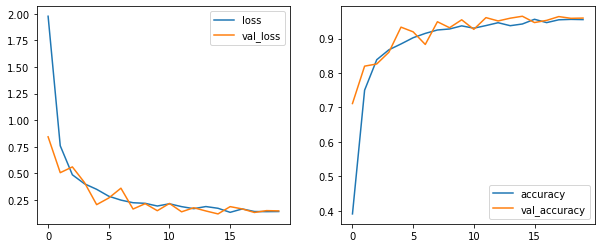

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])
plt.savefig("vgg_performance", facecolor='w', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
vgg.save('vgg.h5')

**ii. With fine tune**

In [ ]:
# freezing all layers of the base model
for layer in conv_base.layers[:-5]:
  layer.trainable = False   # conv_base.trainable = False (same function)

In [ ]:
# add new layers in existence pretrained model
vgg = Flatten()(conv_base.output)
vgg = Dense(512, activation='relu')(vgg)
vgg = Dense(256, activation='relu')(vgg)
vgg = Dense(128, activation='relu')(vgg)
vgg = Dense(64, activation='relu')(vgg)

output_layer = Dense(30, activation='softmax')(vgg)
    
vgg = Model(inputs=conv_base.input, outputs=output_layer)

vgg.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
vgg.compile(
  optimizer = Adam(learning_rate=0.001),
  loss = 'categorical_crossentropy',
  metrics = ['accuracy']
)

In [ ]:
history = vgg.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=30,
      steps_per_epoch=len(train_generator), 
      validation_steps=len(validation_generator), 
      callbacks = [early_stop],
      verbose=1)

Epoch 1/30
329/329 [==============================] - 139s 420ms/step - loss: 2.3330 - accuracy: 0.2920 - val_loss: 1.1676 - val_accuracy: 0.6067
Epoch 2/30
329/329 [==============================] - 138s 419ms/step - loss: 0.9342 - accuracy: 0.6845 - val_loss: 0.5187 - val_accuracy: 0.8240
Epoch 3/30
329/329 [==============================] - 136s 413ms/step - loss: 0.5578 - accuracy: 0.8122 - val_loss: 0.4011 - val_accuracy: 0.8703
Epoch 4/30
329/329 [==============================] - 136s 412ms/step - loss: 0.3836 - accuracy: 0.8727 - val_loss: 0.2651 - val_accuracy: 0.9183
Epoch 5/30
329/329 [==============================] - 136s 414ms/step - loss: 0.3389 - accuracy: 0.8879 - val_loss: 0.1975 - val_accuracy: 0.9377
Epoch 6/30
329/329 [==============================] - 137s 416ms/step - loss: 0.3011 - accuracy: 0.8996 - val_loss: 0.2277 - val_accuracy: 0.9293
Epoch 7/30
329/329 [==============================] - 136s 414ms/step - loss: 0.2536 - accuracy: 0.9136 - val_loss: 0.1768 -

In [ ]:
val_loss, val_accuracy = vgg.evaluate(validation_generator, verbose=1)

94/94 [==============================] - 14s 152ms/step - loss: 0.1538 - accuracy: 0.9540


In [ ]:
test_score = vgg.evaluate(test_generator, verbose=1)

print("Accuracy: {:.2f} %".format(test_score[1]*100)) 
print("Loss: ", test_score[0])

47/47 [==============================] - 7s 158ms/step - loss: 0.2232 - accuracy: 0.9373
Accuracy: 93.73 %
Loss:  0.2231551706790924


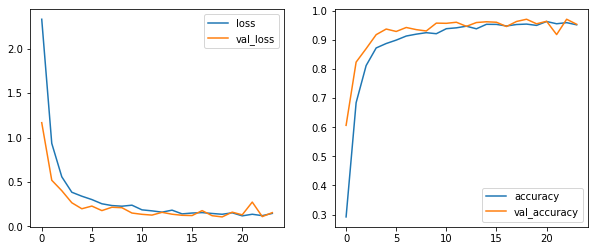

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])
plt.savefig("vgg_performance", facecolor='w', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
classes_name = test_generator.class_indices
print('Dictionary : ', classes_name)
classes_name = list(classes_name.keys())
print('List of class name : ', classes_name)

Dictionary :  {'ahh': 0, 'ba': 1, 'cha': 2, 'chaa': 3, 'dha': 4, 'dza': 5, 'ga': 6, 'ha': 7, 'ja': 8, 'ka': 9, 'kha': 10, 'la': 11, 'ma': 12, 'na': 13, 'nga': 14, 'nya': 15, 'pa': 16, 'pha': 17, 'ra': 18, 'sa': 19, 'sha': 20, 'ta': 21, 'tha': 22, 'tsa': 23, 'tsaaa': 24, 'uaa': 25, 'wa': 26, 'ya': 27, 'za': 28, 'zha': 29}
List of class name :  ['ahh', 'ba', 'cha', 'chaa', 'dha', 'dza', 'ga', 'ha', 'ja', 'ka', 'kha', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'pha', 'ra', 'sa', 'sha', 'ta', 'tha', 'tsa', 'tsaaa', 'uaa', 'wa', 'ya', 'za', 'zha']


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(12,12))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', weight='bold').set_fontsize('12')
  plt.xlabel('Predicted label', weight='bold').set_fontsize('12')

In [ ]:
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

print(target_names)

['ahh', 'ba', 'cha', 'chaa', 'dha', 'dza', 'ga', 'ha', 'ja', 'ka', 'kha', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'pha', 'ra', 'sa', 'sha', 'ta', 'tha', 'tsa', 'tsaaa', 'uaa', 'wa', 'ya', 'za', 'zha']


In [ ]:
Y_pred = vgg.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('\n****************** Performance of Model **************\n')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

47/47 [==============================] - 7s 156ms/step

****************** Performance of Model **************

              precision    recall  f1-score   support

         ahh       0.98      0.86      0.91        50
          ba       0.98      0.94      0.96        50
         cha       1.00      0.80      0.89        50
        chaa       0.82      0.98      0.89        50
         dha       0.94      1.00      0.97        50
         dza       0.96      1.00      0.98        50
          ga       1.00      0.90      0.95        50
          ha       0.89      0.96      0.92        50
          ja       1.00      1.00      1.00        50
          ka       1.00      1.00      1.00        50
         kha       0.96      0.98      0.97        50
          la       0.96      0.92      0.94        50
          ma       0.94      1.00      0.97        50
          na       1.00      0.94      0.97        50
         nga       1.00      0.92      0.96        50
         nya       0.96

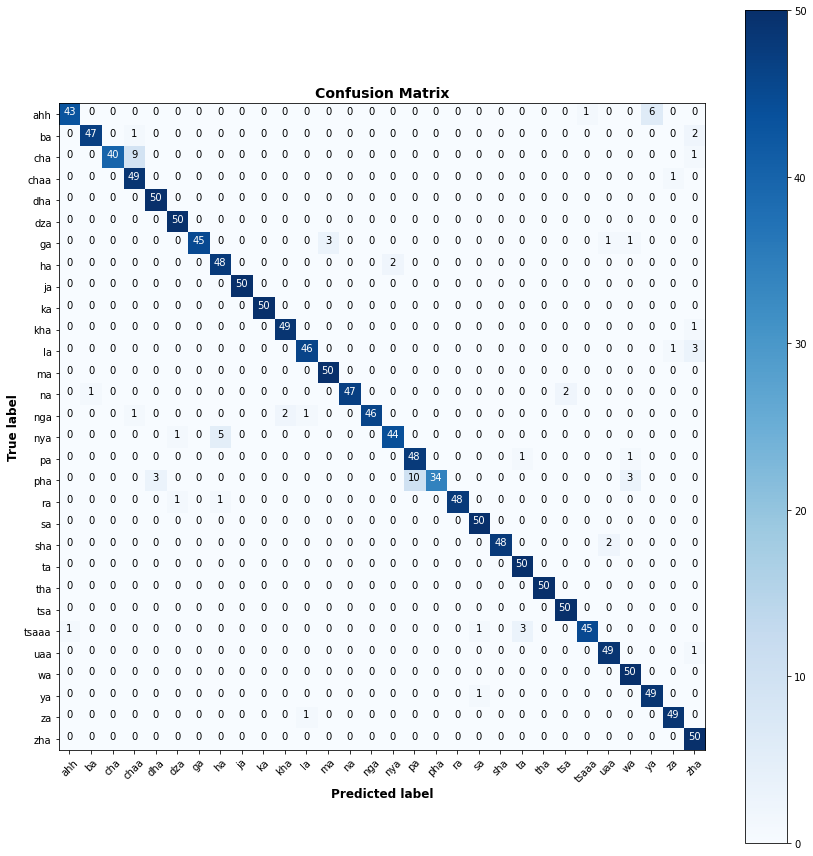

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names)
plt.title('Confusion Matrix', weight='bold').set_fontsize('14')
plt.savefig("vgg_cm", facecolor='w', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
from google.colab import files
from keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  prediction = model.predict(images, batch_size=1)
  print('\n')
  print(prediction[0])

Saving 5.jpg to 5.jpg
1/1 [==============================] - 1s 867ms/step


[7.0172351e-13 1.0036066e-10 6.7504184e-09 2.5927392e-08 8.0491831e-13
 1.8454502e-14 1.1065899e-06 3.3537352e-13 2.2205507e-10 2.9430168e-16
 1.2422753e-10 2.9028424e-13 1.2899880e-08 4.0748919e-12 7.2445237e-15
 2.9308318e-13 2.1147388e-13 8.0126267e-15 2.0108657e-14 1.0166548e-12
 9.8420942e-01 2.0501365e-13 1.0561765e-15 5.7679615e-13 1.7927711e-13
 1.5789434e-02 6.8089605e-12 3.5745433e-13 3.4572196e-09 4.2994600e-10]


In [ ]:
classes = np.argmax(prediction, axis = 1)
classes_list = classes_name[np.argmax(prediction)]
print('The predicted class is {} i.e {}'.format(classes, classes_list))

The predicted class is [20] i.e sha


VGG16 is better than CNN due to its deeper architecture and higher accuracy. The VGG16 architecture consists of 16 layers, including 13 convolutional layers, which allows for better feature extraction and a more accurate prediction of the input image. Overall, VGG16 is better than CNN because it has a deeper architecture, uses smaller kernel sizes, and employs max-pooling layers, which improves the accuracy of image classification tasks.